# Assignment AS02: Recommendation engines (Collaborative Filtering) 

For this assignment we will build and apply an item-based and model-based collaborative filtering recommenders for movies. 

# 0. Preliminaries

## 0.1. Datasets

In the previous practice about Recommendation Engines we used the [MovieLens DataSet](https://grouplens.org/datasets/movielens/) dataset from the Minnesota Research Group (the Grouplens research).  

In this assignment we will continue using the 1M version (`movilens-1M.zip`), that was released on February 2003. The main characteristics are:
* All users selected had rated at least 20 movies
* Each user is represented by an id

The original data are contained in three files: `movies.dat`, `ratings.dat`, and `users.dat`. The descriptions of this 3 files are:

***RATINGS FILE DESCRIPTION***

All ratings are contained in the file `ratings.dat` and are in the following format:

`UserID::MovieID::Rating::Timestamp`

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

**USERS FILE DESCRIPTION**

User information is in the file `users.dat` and is in the following format:

`UserID::Gender::Age::Occupation::Zip-code`

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this dataset.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

***MOVIES FILE DESCRIPTION***


Movie information is in the file `movies.dat` and is in the following format:

`MovieID::Title::Genres`

- Titles are identical to titles provided by the IMDB (including year of release)
- Genres are pipe-separated ("|") and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

## 0.2. Required imports

In [1]:
import numpy as np
import pandas as pd 
from math import*
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import linear_kernel

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## 0.3. Load the data

Load the 3 dataset with Pandas into **ratings**, **users**, and **movies** dataframes considering the data structure explained above. Explore the top 10 registers per dataframe.

In [3]:
# Read the Ratings File
ratings = pd.read_csv("Datasets/ratings.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])


In [4]:
ratings.head(10)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [5]:
# Read the Users File
users = pd.read_csv("Datasets/users.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])

In [6]:
users.head(10)

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [7]:
# Read the Movies File
movies = pd.read_csv("Datasets/movies.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])

In [8]:
movies.head(10)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


[**REPORT**] Create a table per `ratings`,`users`and `movies` dataframes with their main characteristics (i.e. number of rows, number of columns, and type of each column).

In [9]:
print('RATINGS:')
print(ratings.info())
print('----------------------')
print('USERS:')
print(users.info())
print('----------------------')
print('MOVIES:')
print(movies.info())

RATINGS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
movie_id     1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB
None
----------------------
USERS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id       6040 non-null int64
gender        6040 non-null object
age           6040 non-null int64
occupation    6040 non-null int64
zipcode       6040 non-null object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None
----------------------
MOVIES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


# 1. Exploratory Data Analysis

## 1.1. Unique registers

[**REPORT**] Also let's count the number of unique users and movies.

In [10]:
print('Unique users:', len(users['user_id']))
print('Unique movies:', len(movies['title'].unique()))

Unique users: 6040
Unique movies: 3883


## 1.2. "Ratings" variable
To have a clear understanding of the data, it is key to know the distribution of the main variables.
With the **.describe** function of Pandas, we can get a summary of the main statistics of a numeric variable:

In [11]:
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Besides, it is key to know their distribution.

[**REPORT**] Generate a plot with the ditribution of the ratings

Tip: use [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html) with `hist=True, kde=False`

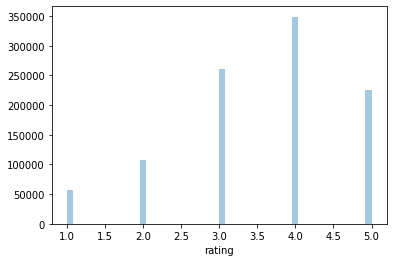

In [12]:
x = ratings['rating']
ax = sns.distplot(x, hist= True, kde=False)
fig = ax.get_figure()
fig.savefig("Tables/ratings_dist.png")

Thanks to this distribution plot, we can observe that ratings are quite high: the mean is over 3 (from 5).


Now, let's join all 3 files into one dataframe and display how this merge looks like.

In [13]:
dataset = pd.merge(pd.merge(movies, ratings),users)
dataset.head(20)

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067
5,531,"Secret Garden, The (1993)",Children's|Drama,1,4,978302149,F,1,10,48067
6,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4,978824268,F,1,10,48067
7,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1,4,978302268,F,1,10,48067
8,595,Beauty and the Beast (1991),Animation|Children's|Musical,1,5,978824268,F,1,10,48067
9,608,Fargo (1996),Crime|Drama|Thriller,1,4,978301398,F,1,10,48067


To see how users evaluated an specific movie, let's filter the merged dataframe for any particular movie, e.g. "Toy Story (1995)"

In [14]:
dataset[dataset["title"]=="Toy Story (1995)"].head(20)

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
53,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50,9,55117
124,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25,12,11413
263,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25,17,61614
369,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35,1,95370
770,1,Toy Story (1995),Animation|Children's|Comedy,18,4,978154768,F,18,3,95825
1075,1,Toy Story (1995),Animation|Children's|Comedy,19,5,978555994,M,1,10,48073
1330,1,Toy Story (1995),Animation|Children's|Comedy,21,3,978139347,M,18,16,99353
1352,1,Toy Story (1995),Animation|Children's|Comedy,23,4,978463614,M,35,0,90049
1656,1,Toy Story (1995),Animation|Children's|Comedy,26,3,978130703,M,25,7,23112


# 2. Recommendation implementations

## 2.1.  Item-based Collaborative filtering

The 2 main types of collaborative filtering algorithms are:
1. **User-based Collaborative Filtering**: This model consists on finding look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. For example, if user A and user B like the same movies and a new movie comes out that user A likes, then we can recommend that movie to user B. 
2. **Item-based Collaborative Filtering**: Here the model try to find movie's look-like instead of user's look-alike. Once the movie's similarity matrix is ready, the recommedation offers alike movies to the ones the user rated previously.

In collaborative filtering, a similarity matrix is built. For user-based, the **user-similarity matrix** will consist of some **distance metrics** that measure the similarity between any two pairs of users. For item-based, the **matrix** will measure the similarity between any two pairs of items.

As we already know, there are several metrics strategy for measure the "similarity" of two items. Some of the most used metrics are Jaccard, Cosine and Pearson. Meanwhile, Jaccard similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B (very useful for those use cases where there is not a numeric rating but just a boolean value like a product being bought), in Pearson and Cosine similarities we measure the similarity between two vectors.

For the purpose of this assignment, we will use **Pearson Similarity** and we will implement a **item-based Collaborative filtering**.


### 2.1.1. Data pre-processing

Firstly, we create a new dataset that merges ratings and movies based on the **movie_id** variable.

In [15]:
data = pd.merge(ratings, movies, on='movie_id')

In [16]:
data.head(5)

,user_id,movie_id,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


[**CODE**] Calculate the mean rating of all movies.

In [17]:
data.groupby(by=['title']).mean()['rating'].head()

title
$1,000,000 Duck (1971)           3.027027
'Night Mother (1986)             3.371429
'Til There Was You (1997)        2.692308
'burbs, The (1989)               2.910891
...And Justice for All (1979)    3.713568
Name: rating, dtype: float64

[**CODE**] Calculate the number of ratings of each movies.

In [18]:
data['title'].value_counts().head()

American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Name: title, dtype: int64

[**CODE**] Create a new `ratings_summary` dataframe with a summary of ratings, containing **title**, **rating average**, and **number of ratings**.

In [19]:
frame = {'rating average': data.groupby(by=['title']).mean()['rating'], 'num of ratings': data['title'].value_counts()} 
ratings_summary = pd.DataFrame(frame)

The Top 10 of the `ratings_summary` dataframe looks like:

In [20]:
ratings_summary.head(10)

,rating average,num of ratings
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199
1-900 (1994),2.500000,2
10 Things I Hate About You (1999),3.422857,700
101 Dalmatians (1961),3.596460,565
101 Dalmatians (1996),3.046703,364
12 Angry Men (1957),4.295455,616


If we sort `ratings_summary` dataframe by the number of ratings, we obtain:

In [21]:
ratings_summary.sort_values('num of ratings', ascending = False).head(10)

,rating average,num of ratings
American Beauty (1999),4.317386,3428
Star Wars: Episode IV - A New Hope (1977),4.453694,2991
Star Wars: Episode V - The Empire Strikes Back (1980),4.292977,2990
Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
Jurassic Park (1993),3.763847,2672
Saving Private Ryan (1998),4.337354,2653
Terminator 2: Judgment Day (1991),4.058513,2649
"Matrix, The (1999)",4.315830,2590
Back to the Future (1985),3.990321,2583
"Silence of the Lambs, The (1991)",4.351823,2578


Before calculating the **similarity matrix**, we create a table where we consolidate all scores for each user in the same raw. Obviously, as number of scored movies per user is much smaller than the number of movies, a lot of **NaN** will appear in our new table.

In [22]:
# Sorting values according to the 'num of rating column' 
ratings_pivot = data.pivot_table(index ='user_id', columns ='title', values ='rating') 

ratings_pivot.head(10) 

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1.2. Item-based collaborative filtering model implementation

Before calculating the recommendation engine for all movies, let's see how the procedure explained before works for a movie. Let's choose the ratings for **'101 Dalmatians (1961)'** movie.

In [23]:
movie1_user_ratings = ratings_pivot['101 Dalmatians (1961)']

In [24]:
movie1_user_ratings.dropna(inplace=True)

In [25]:
print(movie1_user_ratings.head())
print(movie1_user_ratings.tail())

user_id
18    4.0
19    4.0
58    3.0
75    2.0
92    3.0
Name: 101 Dalmatians (1961), dtype: float64
user_id
6015    4.0
6016    3.0
6021    3.0
6032    4.0
6036    4.0
Name: 101 Dalmatians (1961), dtype: float64


To calculate the **similarity** between **'101 Dalmatians (1961)'** and the rest of the movies, let's calculate its Pearson metric and store it in a new dataframe.

Tip: Use [corrwith](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corrwith.html) to calculate Pearson metric.

In [26]:
similar_to_movie1 = ratings_pivot.corrwith(movie1_user_ratings)

C:\Users\roger\Anaconda3\envs\untitled\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\roger\Anaconda3\envs\untitled\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [27]:
corr_movie1 = pd.DataFrame(similar_to_movie1, columns =['Correlation']) 
corr_movie1.dropna(inplace = True)
corr_movie1.sort_values('Correlation', ascending = False).head(10) 
corr_movie1 = corr_movie1.join(ratings_summary['num of ratings'])  

In [28]:
corr_movie1.head() 

,Correlation,num of ratings
title,,
"$1,000,000 Duck (1971)",0.561074,37
'Night Mother (1986),0.220347,70
'Til There Was You (1997),0.457984,52
"'burbs, The (1989)",0.088541,303
...And Justice for All (1979),0.166965,199


Finally, to calculate the similar movies to **'101 Dalmatians (1961)'**, we only have to re-order according to the Pearson value taking into consideration movies with number of ratings higher enough, for instance, 100 of ratings.

In [29]:
corr_movie1[corr_movie1['num of ratings']>100].sort_values('Correlation', ascending = False).head(20)

,Correlation,num of ratings
title,,
101 Dalmatians (1961),1.000000,565
"Rescuers, The (1977)",0.681930,249
Lady and the Tramp (1955),0.676933,864
Madeline (1998),0.671138,116
Red Corner (1997),0.654606,109
Passion Fish (1992),0.653937,147
20 Dates (1998),0.651705,139
Flying Tigers (1942),0.648087,101
Houseguest (1994),0.639940,138


Once we know how the **item-similarity** works for a movie, let's calculate the **item-similarity matrix** for the complete rating dataset.

[**CODE**] Calculate the `item_similarity` matrix by computing Pearson correlations in `ratings_pivot`

In [30]:
item_similarity=ratings_pivot.corr(method='pearson')

In [31]:
display(item_similarity)

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000,0.522233,NaN,0.000000,0.422577,NaN,-0.449490,0.561074,0.150584,0.125209,...,1.000000,-0.106243,NaN,0.000000,NaN,-1.000000,0.000000,NaN,0.944911,-0.500000
'Night Mother (1986),0.522233,1.000000,-0.177705,0.240000,0.216272,NaN,0.266158,0.220347,-0.199239,0.213733,...,0.774597,-0.276359,1.000000,-0.052758,NaN,-0.492518,0.082580,NaN,NaN,0.100372
'Til There Was You (1997),NaN,-0.177705,1.000000,0.712627,0.719676,NaN,0.300273,0.457984,0.564288,0.210259,...,NaN,-0.016137,NaN,0.059235,NaN,NaN,0.183855,NaN,1.000000,0.303731
"'burbs, The (1989)",0.000000,0.240000,0.712627,1.000000,0.089727,NaN,0.189689,0.088541,0.101064,0.047590,...,0.355654,0.278425,NaN,0.158997,NaN,0.080064,0.039503,NaN,0.000000,0.135172
...And Justice for All (1979),0.422577,0.216272,0.719676,0.089727,1.000000,NaN,0.291124,0.166965,-0.142597,0.303093,...,-0.279257,0.052517,0.310087,0.159503,NaN,-0.542037,0.200237,NaN,NaN,-0.024037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",-1.000000,-0.492518,NaN,0.080064,-0.542037,NaN,1.000000,-0.419573,0.944911,0.333333,...,0.866025,0.548795,NaN,-0.072932,NaN,1.000000,0.548844,NaN,NaN,0.296876
Zero Effect (1998),0.000000,0.082580,0.183855,0.039503,0.200237,NaN,0.199307,0.202831,0.071884,0.214276,...,0.106987,0.089512,0.866025,0.064367,NaN,0.548844,1.000000,NaN,NaN,0.392144
Zero Kelvin (Kjærlighetens kjøtere) (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


Your output for the `item_similarity` matrix should look like:

In [80]:
#ORIGINAL
item_similarity

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000,0.522233,NaN,0.000000,0.422577,NaN,-0.449490,0.561074,0.150584,0.125209,...,1.000000,-0.106243,NaN,0.000000,NaN,-1.000000,0.000000,NaN,0.944911,-0.500000
'Night Mother (1986),0.522233,1.000000,-0.177705,0.240000,0.216272,NaN,0.266158,0.220347,-0.199239,0.213733,...,0.774597,-0.276359,1.000000,-0.052758,NaN,-0.492518,0.082580,NaN,NaN,0.100372
'Til There Was You (1997),NaN,-0.177705,1.000000,0.712627,0.719676,NaN,0.300273,0.457984,0.564288,0.210259,...,NaN,-0.016137,NaN,0.059235,NaN,NaN,0.183855,NaN,1.000000,0.303731
"'burbs, The (1989)",0.000000,0.240000,0.712627,1.000000,0.089727,NaN,0.189689,0.088541,0.101064,0.047590,...,0.355654,0.278425,NaN,0.158997,NaN,0.080064,0.039503,NaN,0.000000,0.135172
...And Justice for All (1979),0.422577,0.216272,0.719676,0.089727,1.000000,NaN,0.291124,0.166965,-0.142597,0.303093,...,-0.279257,0.052517,0.310087,0.159503,NaN,-0.542037,0.200237,NaN,NaN,-0.024037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",-1.000000,-0.492518,NaN,0.080064,-0.542037,NaN,1.000000,-0.419573,0.944911,0.333333,...,0.866025,0.548795,NaN,-0.072932,NaN,1.000000,0.548844,NaN,NaN,0.296876
Zero Effect (1998),0.000000,0.082580,0.183855,0.039503,0.200237,NaN,0.199307,0.202831,0.071884,0.214276,...,0.106987,0.089512,0.866025,0.064367,NaN,0.548844,1.000000,NaN,NaN,0.392144
Zero Kelvin (Kjærlighetens kjøtere) (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


[**CODE**] Repeat the previous exercise but only for movies with number of ratings higher than 100.

In [32]:
item_similarity_min_periods=ratings_pivot.corr(method='pearson', min_periods=100)

In [33]:
item_similarity_min_periods

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.088541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zero Effect (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Zero Kelvin (Kjærlighetens kjøtere) (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now the resulting item_similarity looks like: 

In [82]:
#ORIGINAL
item_similarity_min_periods

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.088541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zero Effect (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Zero Kelvin (Kjærlighetens kjøtere) (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Once we have found movie's look-like, we are close to suggest to any user which are the films that best match with his previous preferences. To generate this recommendation list of films for an specific **user_id**, the procedure will be:
- select all the columns corresponding to the films the user_id already watched
- for each column or movie, we will drop the NaN values and multiply each value of its similarity matrix for the rating that user_id evaluated in the past considering it as weight
- we’ll append all the values of all the columns
- groupby title summing the correlation value


[**CODE**] Build a function to `weight_correlation` taking as inputs the **user_id**, the **ratings** pivot table and the previously calculated **item_similarity** matrix. Test the function for **user_id=11**, for instance.

In [34]:
def weighted_user_corr(user_id, ratings, item_similarity_matrix):
    user_correlation=pd.Series()
    rated_by_user = ratings.loc[user_id].dropna()
    filtered_similarity_matrix = item_similarity_matrix
    user_correlation = filtered_similarity_matrix.mul(rated_by_user)
    user_correlation = user_correlation.sum(axis=1)
    return user_correlation

In [35]:
user_id = 11
## ADD YOUR CODE HERE
user_correlation = weighted_user_corr(user_id,ratings_pivot,item_similarity_min_periods)
user_correlation.sort_values(ascending=False).head(20)

title
Good Morning, Vietnam (1987)                          76.103642
Stand by Me (1986)                                    76.028724
Spaceballs (1987)                                     75.838629
Rain Man (1988)                                       75.823302
There's Something About Mary (1998)                   75.747450
Ferris Bueller's Day Off (1986)                       75.147052
Mr. Mom (1983)                                        73.120288
Beetlejuice (1988)                                    72.780843
Big (1988)                                            71.519045
Parenthood (1989)                                     71.248283
Nutty Professor, The (1996)                           70.393826
Wayne's World (1992)                                  70.352602
Awakenings (1990)                                     70.314120
My Cousin Vinny (1992)                                69.988123
Tommy Boy (1995)                                      69.466990
Seven (Se7en) (1995)              

The result of this calculation after sorting by correlation values is:

In [85]:
#ORIGINAL
user_correlation.sort_values(ascending=False).head(20)

Good Morning, Vietnam (1987)                          76.103642
Stand by Me (1986)                                    76.028724
Spaceballs (1987)                                     75.838629
Rain Man (1988)                                       75.823302
There's Something About Mary (1998)                   75.747450
Ferris Bueller's Day Off (1986)                       75.147052
Mr. Mom (1983)                                        73.120288
Beetlejuice (1988)                                    72.780843
Big (1988)                                            71.519045
Parenthood (1989)                                     71.248283
Nutty Professor, The (1996)                           70.393826
Wayne's World (1992)                                  70.352602
Awakenings (1990)                                     70.314120
My Cousin Vinny (1992)                                69.988123
Tommy Boy (1995)                                      69.466990
Seven (Se7en) (1995)                    

[**CODE**] Build the **item_based_recommendation** function to suggest movies according to the previous watched ones for any user. This function should have as inputs the **user_id**, the **ratings** pivot table, the **user_correlation** table calculated before and the **number of recommendations**. Test how it works for **user_id=11**.

In [36]:
def item_based_recommendation(user_id,user_correlation,ratings, num_recommendation=5):
    ## ADD YOUR CODE HERE
    recommended_movies_df = user_correlation.sort_values(ascending=False).index
    watched_movies = []
    recommended_movies = []
    already_seen = [] #EXTRA   
    
    print ("\nAccording to the watched movies: (" + str(len(ratings.iloc[user_id-1].dropna().index)) + ')')
    for watched_movie in ratings.iloc[user_id-1].dropna().index:
        print (watched_movie)
        watched_movies.append(watched_movie)
    
    print ("\nTop",num_recommendation,"recommended movies:\n")
    for recommended_movie in recommended_movies_df:
        if recommended_movie in watched_movies:
            already_seen.append(recommended_movie)
            continue
        print(recommended_movie)
        recommended_movies.append(recommended_movie)
        if len(recommended_movies) == num_recommendation:
            break
    #print(already_seen)  
    return user_correlation

In [37]:
num_recommendations = 10
movie_recommendation = item_based_recommendation(user_id,user_correlation,ratings_pivot, num_recommendations)


According to the watched movies: (137)
Adventures of Priscilla, Queen of the Desert, The (1994)
Adventures of Sebastian Cole, The (1998)
Airplane! (1980)
Almost Heroes (1998)
American Beauty (1999)
American History X (1998)
American Pie (1999)
Analyze This (1999)
Angels and Insects (1995)
As Good As It Gets (1997)
Austin Powers: The Spy Who Shagged Me (1999)
Awakenings (1990)
Backdraft (1991)
Bean (1997)
Beetlejuice (1988)
Being John Malkovich (1999)
Benny & Joon (1993)
Big Lebowski, The (1998)
Big Night (1996)
Billy Madison (1995)
Black Sheep (1996)
Blair Witch Project, The (1999)
Blue Velvet (1986)
Boogie Nights (1997)
Braveheart (1995)
Breakfast of Champions (1999)
Buffalo 66 (1998)
Bug's Life, A (1998)
Cable Guy, The (1996)
Caddyshack (1980)
Christmas Story, A (1983)
Cider House Rules, The (1999)
Coneheads (1993)
Dances with Wolves (1990)
Dave (1993)
Dazed and Confused (1993)
Dead Man Walking (1995)
Deconstructing Harry (1997)
Deuce Bigalow: Male Gigolo (1999)
Dream With the Fishe

Verify your results are similar to:

In [87]:
#ORIGINAL
num_recommendations = 10
movie_recommendation = item_based_recommendation(user_id,user_correlation,ratings_pivot, num_recommendations)


According to the watched movies:

Adventures of Priscilla, Queen of the Desert, The (1994)
Adventures of Sebastian Cole, The (1998)
Airplane! (1980)
Almost Heroes (1998)
American Beauty (1999)
American History X (1998)
American Pie (1999)
Analyze This (1999)
Angels and Insects (1995)
As Good As It Gets (1997)
Austin Powers: The Spy Who Shagged Me (1999)
Awakenings (1990)
Backdraft (1991)
Bean (1997)
Beetlejuice (1988)
Being John Malkovich (1999)
Benny & Joon (1993)
Big Lebowski, The (1998)
Big Night (1996)
Billy Madison (1995)
Black Sheep (1996)
Blair Witch Project, The (1999)
Blue Velvet (1986)
Boogie Nights (1997)
Braveheart (1995)
Breakfast of Champions (1999)
Buffalo 66 (1998)
Bug's Life, A (1998)
Cable Guy, The (1996)
Caddyshack (1980)
Christmas Story, A (1983)
Cider House Rules, The (1999)
Coneheads (1993)
Dances with Wolves (1990)
Dave (1993)
Dazed and Confused (1993)
Dead Man Walking (1995)
Deconstructing Harry (1997)
Deuce Bigalow: Male Gigolo (1999)
Dream With the Fishes (19

## 2.2.  Model-based Collaborative filtering

Matrix Factorization is a technique very used in recommendation engines because it "captures" the **latent** preferences of users and the **latent** attributes of items. In other words, Matrix Factorization in recommendation engines learns features (from users and items) that describe the characteristics of ratings. Once these **latent** preferences of users and attributes are "known", we can use them to predict the unknown ratings through the combination fo both latent features. 
In parallel, another benefit of Matrix Factorization is in case of sparse matrix. By means of Matrix Factorization we can reduce the original matrix in a low-rank one withouth the penalty of losing information.  

In a nutshell, model-based collaboration filtering has a good performance because it **captures** the latent preferencies and attributes of users and items respectively in scenarios with high sparsity of data.

For our movies recommendation use case, let's check the sparcity:

In [38]:
n_users = len(dataset['user_id'].unique())
n_movies = len(dataset['movie_id'].unique())

sparse_ratings_pivot= round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print ("The sparsity is:"+  str(sparse_ratings_pivot * 100) + "%")

The sparsity is:95.5%


that confirms that this dataset is a good candidate to use Matrix Factorization technique.

Let's create the **rating_pivot** dataframe again but now with headers as **movie_id**'s instead of **movie's names**.

In [39]:
ratings_pivot = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating')
ratings_pivot.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
#ORIGINAL
ratings_pivot = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating')
ratings_pivot.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before applying Matrix Factorization, we should process the dataframe. Firstly, we calculate the rating average per user ID, fill **NaN** values and normalize the rating table.

[**REPORT**] Include in your report a table with the mean of rating per user (for a sample of a few users).

In [40]:
ratings_pivot_means = ratings_pivot.head(20).mean(axis=1)
display(ratings_pivot_means)

user_id
1     4.188679
2     3.713178
3     3.901961
4     4.190476
5     3.146465
6     3.901408
7     4.322581
8     3.884892
9     3.735849
10    4.114713
11    3.277372
12    3.826087
13    3.388889
14    3.320000
15    3.323383
16    3.028571
17    4.075829
18    3.649180
19    3.572549
20    4.083333
dtype: float64

[**CODE**] Fill **NaN** values of the ratings_pivot dataframe with 0.

In [41]:
ratings_pivot = ratings_pivot.fillna(0)
display(ratings_pivot)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's re-calculate the mean of the user ratings as follows:

In [42]:
user_ratings_mean=np.array(ratings_pivot.mean(axis=1))
print(user_ratings_mean)

[0.05990286 0.12924987 0.05369671 ... 0.02050729 0.1287102  0.3291959 ]


[**CODE**] Normalize  (i.e. rating_value-mean) ratings table and name the resulting matrix as **ratings_normalized**.

In [43]:
#Took long, must review
ratings_normalized = []
for i in range(len(np.array(ratings_pivot))):
    #print(i, '/', len(np.array(ratings_pivot)))
    ratings_normalized.append(np.array(ratings_pivot)[i] - user_ratings_mean[i])  

print(ratings_normalized)

[array([ 4.94009714, -0.05990286, -0.05990286, ..., -0.05990286,
       -0.05990286, -0.05990286]), array([-0.12924987, -0.12924987, -0.12924987, ..., -0.12924987,
       -0.12924987, -0.12924987]), array([-0.05369671, -0.05369671, -0.05369671, ..., -0.05369671,
       -0.05369671, -0.05369671]), array([-0.02374528, -0.02374528, -0.02374528, ..., -0.02374528,
       -0.02374528, -0.02374528]), array([-0.16810577, -0.16810577, -0.16810577, ..., -0.16810577,
       -0.16810577, -0.16810577]), array([ 3.92525634, -0.07474366, -0.07474366, ..., -0.07474366,
       -0.07474366, -0.07474366]), array([-0.03615758, -0.03615758, -0.03615758, ..., -0.03615758,
       -0.03615758, -0.03615758]), array([ 3.85429034, -0.14570966, -0.14570966, ..., -0.14570966,
       -0.14570966, -0.14570966]), array([ 4.89314625, -0.10685375, -0.10685375, ..., -0.10685375,
       -0.10685375, -0.10685375]), array([ 4.55477604,  4.55477604, -0.44522396, ..., -0.44522396,
       -0.44522396, -0.44522396]), array([-0

After normalizing you should obtain the following ratings matrix:

In [99]:
#ORIGINAL
ratings_normalized

array([[ 4.94009714, -0.05990286, -0.05990286, ..., -0.05990286,
        -0.05990286, -0.05990286],
       [-0.12924987, -0.12924987, -0.12924987, ..., -0.12924987,
        -0.12924987, -0.12924987],
       [-0.05369671, -0.05369671, -0.05369671, ..., -0.05369671,
        -0.05369671, -0.05369671],
       ...,
       [-0.02050729, -0.02050729, -0.02050729, ..., -0.02050729,
        -0.02050729, -0.02050729],
       [-0.1287102 , -0.1287102 , -0.1287102 , ..., -0.1287102 ,
        -0.1287102 , -0.1287102 ],
       [ 2.6708041 , -0.3291959 , -0.3291959 , ..., -0.3291959 ,
        -0.3291959 , -0.3291959 ]])

[**REPORT**] Create a table with the rating **normalize** it and the average rating for the user_ids 0 to 4. 

In [44]:
report_table = pd.DataFrame(ratings_normalized[0:5])
report_table.insert(6, 'real mean', ratings_pivot_means.reset_index(drop=True).head()) 
report_table.insert(7, 'mean with the 0s', user_ratings_mean[0:5])
display(report_table.loc[:,:'mean with the 0s'])
report_table.loc[:,:'mean with the 0s'].to_csv("Tables/rating_normalized.csv")

,0,1,2,3,4,5,real mean,mean with the 0s
0,4.940097,-0.059903,-0.059903,-0.059903,-0.059903,-0.059903,4.188679,0.059903
1,-0.129250,-0.129250,-0.129250,-0.129250,-0.129250,-0.129250,3.713178,0.129250
2,-0.053697,-0.053697,-0.053697,-0.053697,-0.053697,-0.053697,3.901961,0.053697
3,-0.023745,-0.023745,-0.023745,-0.023745,-0.023745,-0.023745,4.190476,0.023745
4,-0.168106,-0.168106,-0.168106,-0.168106,-0.168106,1.831894,3.146465,0.168106


[**CODE**] Calculate U, Sigma and V transpose for a number of latent factors of k=50.

Tip: Use [svds](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) function to calculate U, Sigma and V.

In [45]:
U, Sigma, V = svds(ratings_normalized, k=50)

[**REPORT**] Verify the shape of each matrix (U, Sigma and V transpose). Are they correct? Why?

In [46]:
print('U:', U.shape)
print('Sigma:', Sigma.shape)
print('V Transpose:', V.shape)

U: (6040, 50)
Sigma: (50,)
V Transpose: (50, 3706)


Your Sigma matrix should look like this: 

In [103]:
#ORIGINAL
Sigma

array([ 147.18581225,  147.62154312,  148.58855276,  150.03171353,
        151.79983807,  153.96248652,  154.29956787,  154.54519202,
        156.1600638 ,  157.59909505,  158.55444246,  159.49830789,
        161.17474208,  161.91263179,  164.2500819 ,  166.36342107,
        166.65755956,  167.57534795,  169.76284423,  171.74044056,
        176.69147709,  179.09436104,  181.81118789,  184.17680849,
        186.29341046,  192.15335604,  192.56979125,  199.83346621,
        201.19198515,  209.67692339,  212.55518526,  215.46630906,
        221.6502159 ,  231.38108343,  239.08619469,  244.8772772 ,
        252.13622776,  256.26466285,  275.38648118,  287.89180228,
        315.0835415 ,  335.08085421,  345.17197178,  362.26793969,
        415.93557804,  434.97695433,  497.2191638 ,  574.46932602,
        670.41536276, 1544.10679346])

In [47]:
#MY OUTPUT
Sigma

array([ 147.18581225,  147.62154312,  148.58855276,  150.03171353,
        151.79983807,  153.96248652,  154.29956787,  154.54519202,
        156.1600638 ,  157.59909505,  158.55444246,  159.49830789,
        161.17474208,  161.91263179,  164.2500819 ,  166.36342107,
        166.65755956,  167.57534795,  169.76284423,  171.74044056,
        176.69147709,  179.09436104,  181.81118789,  184.17680849,
        186.29341046,  192.15335604,  192.56979125,  199.83346621,
        201.19198515,  209.67692339,  212.55518526,  215.46630906,
        221.6502159 ,  231.38108343,  239.08619469,  244.8772772 ,
        252.13622776,  256.26466285,  275.38648118,  287.89180228,
        315.0835415 ,  335.08085421,  345.17197178,  362.26793969,
        415.93557804,  434.97695433,  497.2191638 ,  574.46932602,
        670.41536276, 1544.10679346])

As Sigma is a numpy array, we need to transform it to a Diagonal matrix before generating the predictions.

[**CODE**] Transform Sigma into a Diagonal matrix and check the shape of the result.

Tip: [diag](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.diag.html) will help us to build the diagonal matrix.

In [48]:
Sigma = np.diag(Sigma)

After transforming to diagonal, Sigma takes this shape:

In [106]:
#ORIGINAL
Sigma[0:5,0:5]

array([[147.18581225,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        , 147.62154312,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        , 148.58855276,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        , 150.03171353,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        151.79983807]])

In [49]:
#MY OUTPUT
Sigma[0:5,0:5]

array([[147.18581225,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        , 147.62154312,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        , 148.58855276,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        , 150.03171353,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        151.79983807]])

[**CODE**] Create the prediction of ratings using **U**, **Sigma**, **Vt** and **user_ratings_mean**

In [50]:
user_ratings_mean_matrix = []
length = U.dot(Sigma).dot(V).shape[1]
for i in range(len(user_ratings_mean)):
    user_ratings_mean_matrix.append([user_ratings_mean[i]]*length)
all_user_predicted_ratings = U.dot(Sigma).dot(V) + np.array(user_ratings_mean_matrix)
all_user_predicted_ratings

array([[ 4.28886061,  0.14305516, -0.1950795 , ...,  0.03191195,
         0.05044975,  0.08891033],
       [ 0.74471587,  0.16965927,  0.33541808, ..., -0.10110207,
        -0.0540982 , -0.14018846],
       [ 1.81882382,  0.45613623,  0.09097801, ...,  0.01234452,
         0.01514752, -0.10995596],
       ...,
       [ 0.61908871, -0.16176859,  0.10673806, ..., -0.01336948,
        -0.0303543 , -0.11493552],
       [ 1.50360483, -0.03620761, -0.16126817, ..., -0.01090407,
        -0.03864749, -0.16835943],
       [ 1.99624816, -0.18598715, -0.1564782 , ..., -0.00664061,
         0.12706713,  0.28500112]])

Once we have calculated the predictions, we are ready to store into a `predicted_ratings` dataframe.

In [51]:
predicted_ratings = pd.DataFrame(all_user_predicted_ratings, columns = ratings_pivot.columns)

Let's look how the prediction are:

In [52]:
predicted_ratings

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,2.392388,0.233964,0.413676,0.443726,-0.083641,2.192294,1.168936,0.145237,-0.046551,0.560895,...,0.188493,-0.004439,-0.042271,-0.090101,0.276312,0.133806,0.732374,0.271234,0.244983,0.734771
6036,2.070760,0.139294,-0.012666,-0.176990,0.261243,1.074234,0.083999,0.013814,-0.030179,-0.084956,...,-0.161548,0.001184,-0.029223,-0.047087,0.099036,-0.192653,-0.091265,0.050798,-0.113427,0.033283
6037,0.619089,-0.161769,0.106738,0.007048,-0.074701,-0.079953,0.100220,-0.034013,0.007671,0.001280,...,-0.053546,0.005835,0.007551,-0.024082,-0.010739,-0.008863,-0.099774,-0.013369,-0.030354,-0.114936
6038,1.503605,-0.036208,-0.161268,-0.083401,-0.081617,-0.143517,0.106668,-0.054404,-0.008826,0.205801,...,-0.006104,0.008933,0.007595,-0.037800,0.050743,0.024052,-0.172466,-0.010904,-0.038647,-0.168359


[**REPORT**] Which is the prediction for **Movie_id=364** and **User_id=0**? Verify that before prediction, the user rate was 0.

In [53]:
movie_id = 364
user_id = 0
print('Prediction:', predicted_ratings.loc[user_id][movie_id+1])
print('Value:', ratings_pivot[user_id+1][movie_id+1])

Prediction: -0.0005820643291043343
Value: 0.0


[**REPORT**] Which is the prediction for **Movie_id=0** and **User_id=0**? Verify that before prediction, the user rate was 5.

In [54]:
movie_id = 0
user_id = 0
print('Prediction:', predicted_ratings.loc[user_id][movie_id+1])
print('Value:',ratings_pivot[user_id+1][movie_id+1])

Prediction: 4.288860613705928
Value: 5.0


Once we have the ratings for pending movies, we have to build a recommendation function that suggest the **num_recommendations** movies to any user_id.

[**CODE**] Develop a model_based_recommendation function that suggest **num_recommendations** movies to a **user_id**. The structure of this function should be:
- inputs: the **prediction_ratings**, **original_ratings**, the **movies** dataset and **user_id**
- outputs:
    - A dataframe with the original rates from **user_id** joined with movies
    - A dataframe with **num_recommendations** rows and the following columns: **movie_id**, **title**, **genres** and **predicted_rate**
    
    
To facilitate the model_based_recommendation function design, we will provide a `ratings_preparation`function responsible for adding movie information predictions.

In [55]:
def ratings_preparation(predictions, userID, movies, original_ratings):
    user_row_number = userID - 1 # User ID starts at 1, not 0
    
    # Get the user's data and merge in the movie information.
    user_ratings = original_ratings[original_ratings.user_id == (userID)]
    user_ratings_complete = (user_ratings.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False))
    
    print ("User", userID,"has already rated",user_ratings_complete.shape[0],"movies")
    return user_ratings_complete

In [56]:
def model_based_recommendations(predictions, userID, movies, original_ratings, num_recommendations):
    user_row_number = userID - 1 # User ID starts at 1, not 0
    
    #Get and sort the user's predictions
    #ADD YOUR CODE
    
    #Prepare the user_ratings adding movie information and ordering by ratings value and 
    user_ratings_complete=ratings_preparation(predictions, userID, movies, original_ratings)
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    #ADD YOUR CODE
    user_predictions = predictions.drop(predictions.columns[user_ratings_complete.movie_id], axis=1).loc[user_row_number]
    filtered_movies = movies.merge(user_predictions.reset_index()) 
    filtered_movies = filtered_movies.rename({0: "predicted_rate"}, axis='columns').sort_values(by='predicted_rate', ascending=False)
    recommendations = filtered_movies[(~filtered_movies.movie_id.isin(user_ratings_complete.movie_id))].head(num_recommendations)
        
    return user_ratings_complete, recommendations

[**REPORT**] Generate a table with the Top 20 movies that User_id=1 rated

In [57]:
user_ratings_complete=ratings_preparation(predicted_ratings, 1, movies, ratings)
user_ratings_complete.head(20).to_csv("Tables/top_movies_rated.csv")
display(user_ratings_complete.head(20))

User 1 has already rated 53 movies


,user_id,movie_id,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
46,1,1029,5,978302205,Dumbo (1941),Animation|Children's|Musical
40,1,1,5,978824268,Toy Story (1995),Animation|Children's|Comedy
18,1,3105,5,978301713,Awakenings (1990),Drama
41,1,1961,5,978301590,Rain Man (1988),Drama
23,1,527,5,978824195,Schindler's List (1993),Drama|War
37,1,1022,5,978300055,Cinderella (1950),Animation|Children's|Musical
14,1,1035,5,978301753,"Sound of Music, The (1965)",Musical
25,1,48,5,978824351,Pocahontas (1995),Animation|Children's|Musical|Romance
45,1,1028,5,978301777,Mary Poppins (1964),Children's|Comedy|Musical


In [58]:
#Let's call the function we have just created:
original_ratings_user_id, predicted_ratings_user_id = model_based_recommendations(predicted_ratings, 1, movies, ratings, 20)

User 1 has already rated 53 movies


[**REPORT**] Generate a table with the Top 20 movies recommended for User_id=1

In [59]:
#MY OUTPUT
predicted_ratings_user_id.to_csv("Tables/top_movies_recomended.csv")
predicted_ratings_user_id

,movie_id,title,genres,predicted_rate
305,318,"Shawshank Redemption, The (1994)",Drama,2.696711
32,34,Babe (1995),Children's|Comedy|Drama,2.641693
350,364,"Lion King, The (1994)",Animation|Children's|Musical,2.570582
1868,2081,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance,2.211835
1168,1282,Fantasia (1940),Animation|Children's|Musical,1.914000
1867,2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance,1.771934
1865,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical,1.752588
1882,2096,Sleeping Beauty (1959),Animation|Children's|Musical,1.733825
1874,2087,Peter Pan (1953),Animation|Children's|Fantasy|Musical,1.678037
342,356,Forrest Gump (1994),Comedy|Romance|War,1.672865


The Top 20 recommended movies should be:

In [549]:
# Solution
predicted_ratings_user_id

,movie_id,title,genres,predicted_rate
311,318,"Shawshank Redemption, The (1994)",Drama,2.838021
32,34,Babe (1995),Children's|Comedy|Drama,2.727769
356,364,"Lion King, The (1994)",Animation|Children's|Musical,2.649038
1975,2081,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance,2.245426
1235,1282,Fantasia (1940),Animation|Children's|Musical,1.939844
1974,2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance,1.795402
1990,2096,Sleeping Beauty (1959),Animation|Children's|Musical,1.760940
1972,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical,1.735026
1981,2087,Peter Pan (1953),Animation|Children's|Fantasy|Musical,1.714467
348,356,Forrest Gump (1994),Comedy|Romance|War,1.713598


[**REPORT**] Create a table that compares the pros and cons of content-based recommendation engine, item-based, user-based and model-based collaborative filterings in terms of cost computation, cold start and any other aspect you consider.

Due to recommendation engines is a key area in Artificial Intelligence, the **Open Source** community has developed several tools to facilitate the implementation and usage of this kind of techniques. **[Surprise](http://surpriselib.com/)** is one of the most interesting iniciative and it is a Python scikit building and analyzing recommender systems.

In the following lines, we are using **Surprise** to replicate our previous model-based model and evaluate its performance for MovieLens dataset

Let's load the rating dataset once again.

In [60]:
# Read the Ratings File
ratings = pd.read_csv("Datasets/ratings.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userID', 'itemID', 'rating','timestamp'])


**Surprise** is quite sensitive to a specific dataframe structure: ['userID', 'itemID', 'rating']. Therefore, we have to drop the **timestamp** column.

In [61]:
ratings=ratings.drop(columns="timestamp")

Let's import the specific **Surprise** libraries.

In [62]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

Finally, we create the code to train and test the model-based collaboration filtering. The evaluation is done using RMSE (Root Mean Square Error) implemented in [surprise.accuracy.rmse](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse).

In [63]:
#Reorder the columns
ratings=ratings[['itemID','userID','rating']]
df = pd.DataFrame(ratings)
# A reader is needed specifying the rating_scale param in our use case (1 to 5).
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# define the Single-Value Descomposition model from Surprise library
model = SVD()

#Split the dataset into test (20%) and training (80%)
trainset, testset = train_test_split(data, test_size=.20)


# train and test algorithm.
model.fit(trainset)
predictions = model.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions, verbose=True)

RMSE: 0.8737


0.8736655801986536

[**REPORT**] Create a table with 5 predictions and explain results. Which is your opinion about SVD performance? Why?

In [64]:
predictions[0:5]

[Prediction(uid=1758, iid=3101, r_ui=4.0, est=3.605519670951504, details={'was_impossible': False}),
 Prediction(uid=2265, iid=110, r_ui=4.0, est=4.446057286419635, details={'was_impossible': False}),
 Prediction(uid=223, iid=292, r_ui=5.0, est=3.658067537172183, details={'was_impossible': False}),
 Prediction(uid=721, iid=316, r_ui=3.0, est=3.6575321308850395, details={'was_impossible': False}),
 Prediction(uid=570, iid=340, r_ui=4.0, est=3.2763637271981354, details={'was_impossible': False})]

[**CODE**] Repeat the previous exercise but with k-fold cross-validation, where k=5. This means splitting the dataset into 5 groups (or *folds*), and then using 4 groups for training and one group for testing. The testing group changes in each iteration. 

Tip: use Surprise's [KFold](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.split.KFold) class.

In [66]:
# define a cross-validation iterator
## ADD YOUR CODE
kf = KFold(n_splits=5)

In [67]:
#Train, test the algoritm and compute RMSE in each iteration
for trainset, testset in kf.split(data):
    # train and test algorithm.
    ## ADD YOUR CODE
    model = SVD()
    model.fit(trainset)
    predictions = model.test(testset)

    # Compute and print Root Mean Squared Error
    ## ADD YOUR CODE
    accuracy.rmse(predictions, verbose=True)    

RMSE: 0.8738
RMSE: 0.8747
RMSE: 0.8732
RMSE: 0.8738
RMSE: 0.8750


# Deliver (groups of two)

Deliver:

* A zip file containing your notebook (.ipynb file) with all the "[**CODE**]" parts implemented.
* A 4-pages PDF report including all parts of this notebook marked with "[**REPORT**]"

The report should end with the following statement: **We hereby declare that, except for the code provided by the course instructors, all of our code, report, and figures were produced by ourselves.**